In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('/kaggle/input/walmartcleaned/walmart_cleaned.csv')

In [4]:
df

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

# Convert Date to datetime if not already in datetime format
#df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Stationarity Check and Transformations
def check_stationarity(series):
    """
    Checks for stationarity using the Augmented Dickey-Fuller test.

    Args:
    series: A pandas Series representing the time series data.

    Returns:
    A boolean indicating if the series is stationary.
    """
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    return result[1] <= 0.05

# Assuming 'Weekly_Sales' is your time series data column
is_stationary = check_stationarity(df['Weekly_Sales'])

if not is_stationary:                                                                                                                     
    df['Weekly_Sales_Log'] = np.log(df['Weekly_Sales'])  # Logarithmic transformation
    df['Weekly_Sales_Diff'] = df['Weekly_Sales'].diff()  # Differencing
    # ... (other transformations as needed)

# Feature Engineering
# Seasonal Indicators
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Season'] = (df['Month'] % 12 + 3) // 3  # Divide months into 4 seasons

# Holiday Flags (Example for Super Bowl)
super_bowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']
df['SuperBowl'] = df['Date'].isin(pd.to_datetime(super_bowl_dates))

# Check if 'Holiday_Flag' exists before applying get_dummies
if 'Holiday_Flag' in df.columns:
    df = pd.get_dummies(df, columns=['Holiday_Flag'], prefix=['Holiday'])  # One-hot encoding

# Rolling and Lagged Features
df['RollingMean_Weekly_Sales'] = df['Weekly_Sales'].rolling(window=4).mean()  # 4-week rolling average
df['Lagged_Weekly_Sales'] = df['Weekly_Sales'].shift(1)  # Previous week's sales

# Scaling Numerical Features
scaler = StandardScaler()
numerical_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']  # Add more features if needed
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Drop rows with NaN values created by rolling and lagged features
df = df.dropna()


ADF Statistic: -14.375262247838243
p-value: 9.347628636587609e-27
Critical Values: {'1%': -3.430365515589113, '5%': -2.8615468577049468, '10%': -2.56677365010633}


/tmp/ipykernel_30/538801255.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WeekOfYear'] = df['Date'].dt.isocalendar().week
/tmp/ipykernel_30/538801255.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Date'].dt.month
/tmp/ipykernel_30/538801255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

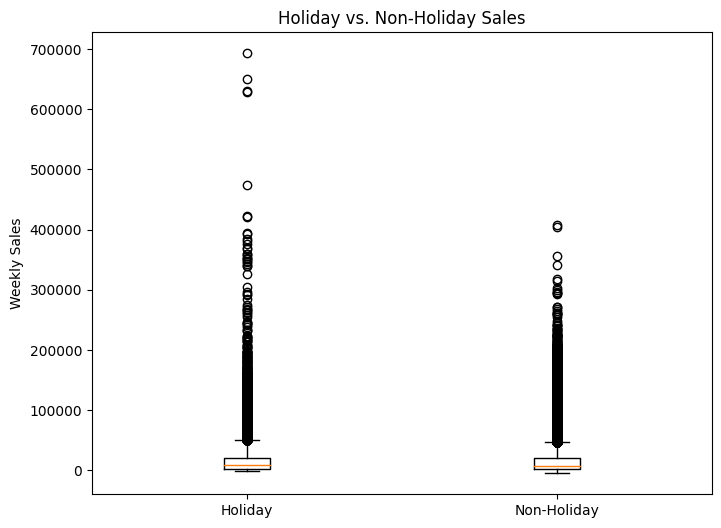

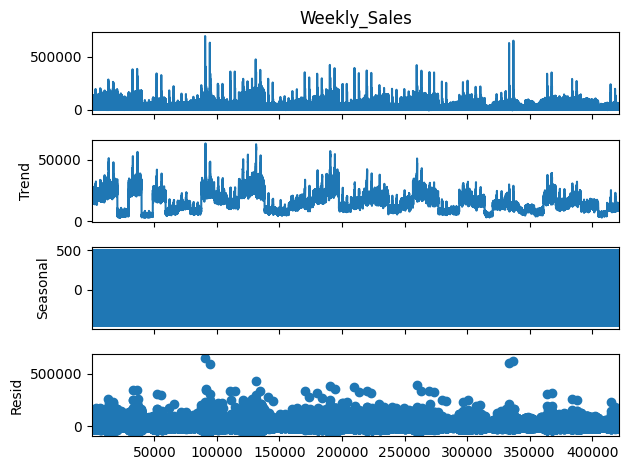

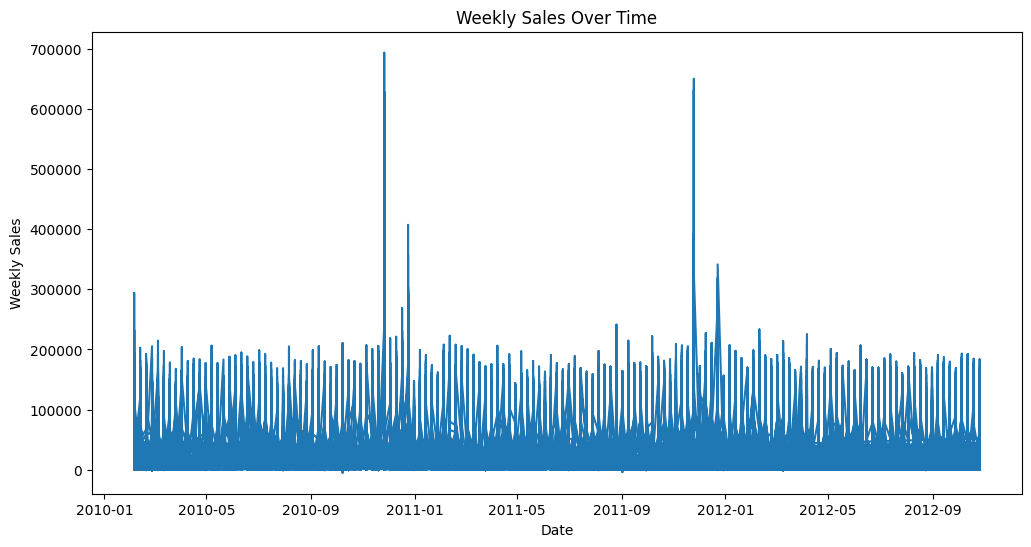

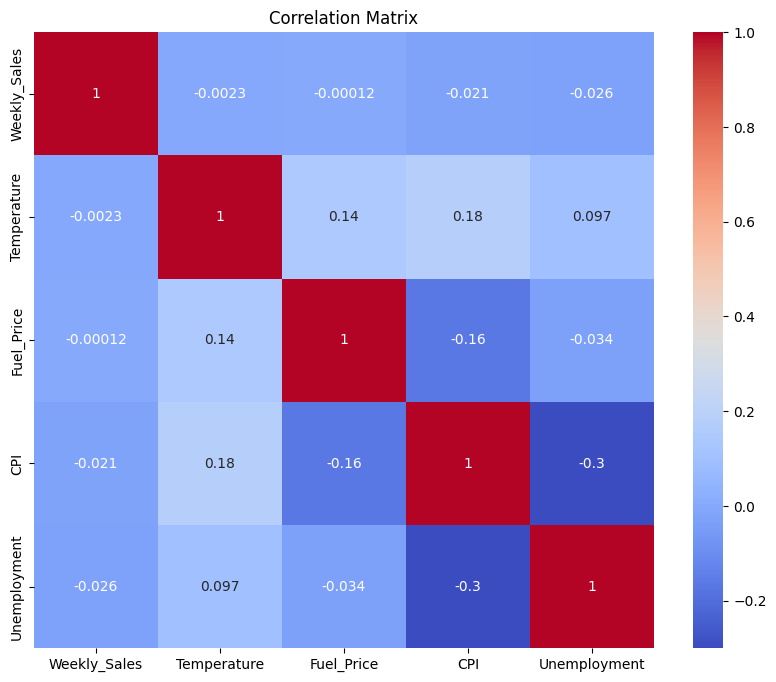

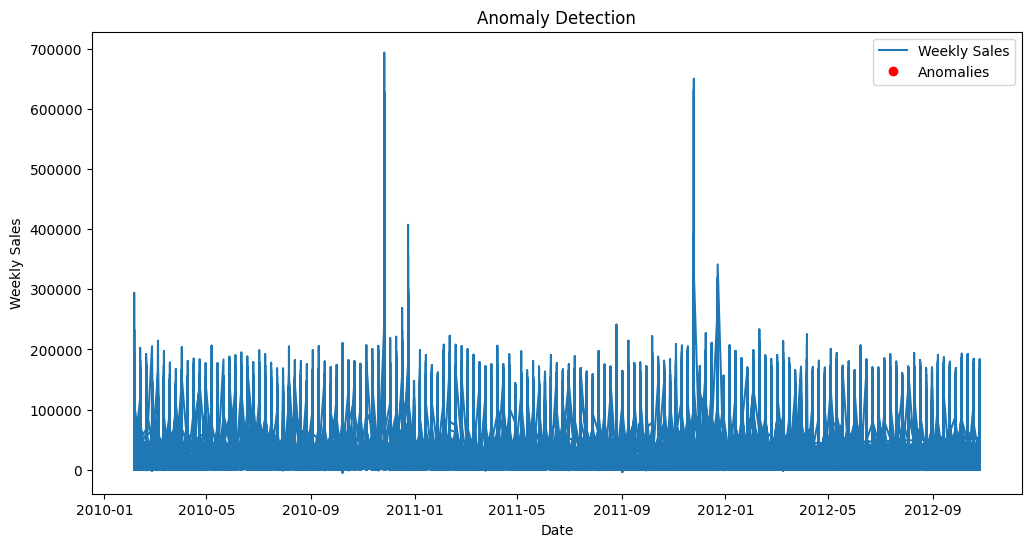

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# ... (Your existing code for data loading and preprocessing)

# Specify the seasonal period; for example, 52 if you expect annual seasonality in weekly data
period = 52
decomposition = seasonal_decompose(df['Weekly_Sales'], model='additive', period=period)

# Plot the decomposed components
decomposition.plot()
plt.show()

# Holiday Sales Comparison (using 'IsHoliday' column)
holiday_sales = df[df['IsHoliday'] == 1]['Weekly_Sales']  # Use 'IsHoliday'
non_holiday_sales = df[df['IsHoliday'] == 0]['Weekly_Sales']  # Use 'IsHoliday'
plt.figure(figsize=(8, 6))
plt.boxplot([holiday_sales, non_holiday_sales], labels=['Holiday', 'Non-Holiday'])
plt.title('Holiday vs. Non-Holiday Sales')
plt.ylabel('Weekly Sales')
plt.show()


# Seasonal decomposition
result = seasonal_decompose(df['Weekly_Sales'], model='additive', period=52)  # Assuming weekly seasonality
result.plot()
plt.show()

# Time-series plot for Weekly_Sales
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Weekly_Sales'])
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


# Correlation Analysis
correlation_matrix = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Anomaly Detection
# Calculate rolling average and standard deviation
df['RollingMean'] = df['Weekly_Sales'].rolling(window=4).mean()
df['RollingStd'] = df['Weekly_Sales'].rolling(window=4).std()

# Define anomaly threshold (e.g., 2 standard deviations from the rolling mean)
threshold = 2

# Identify anomalies
df['Anomaly'] = (df['Weekly_Sales'] > df['RollingMean'] + threshold * df['RollingStd']) | \
                 (df['Weekly_Sales'] < df['RollingMean'] - threshold * df['RollingStd'])

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Weekly_Sales'], label='Weekly Sales')
plt.plot(df['Date'][df['Anomaly']], df['Weekly_Sales'][df['Anomaly']], 'ro', label='Anomalies')
plt.title('Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# ... (Your existing code for data loading and preprocessing)

# Train-Test Split (Time-based)
# Assuming 'Date' is your time column
train_data = df[df['Date'] < '2012-01-01']  # Adjust the date for your desired split
test_data = df[df['Date'] >= '2012-01-01']

# Handling Non-Stationarity (Example with Differencing)
# Assuming 'Weekly_Sales' is your target variable
train_data['Weekly_Sales_Diff'] = train_data['Weekly_Sales'].diff()
test_data['Weekly_Sales_Diff'] = test_data['Weekly_Sales'].diff()
# ... (Apply other transformations like log or seasonal decomposition as needed)

# Feature Selection (Using Random Forest)
# Define your features and target
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'WeekOfYear', 'Month', 'Season',
            'RollingMean_Weekly_Sales', 'Lagged_Weekly_Sales']  # Add or remove features
target = 'Weekly_Sales_Diff'  # Use the transformed target if applied

# Create and train a Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(train_data[features], train_data[target])

# Get feature importances
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize feature importances
print(feature_importance_df)
# ... (Plot feature importances using a bar chart, etc.)

# Select top features based on importance
selected_features = feature_importance_df['Feature'][:5].tolist()  # Select top 5 features, adjust as needed
# ... (Use selected_features for model training)

/tmp/ipykernel_30/2107502234.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Weekly_Sales_Diff'] = train_data['Weekly_Sales'].diff()
/tmp/ipykernel_30/2107502234.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Weekly_Sales_Diff'] = test_data['Weekly_Sales'].diff()


ValueError: Input y contains NaN.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from arch import arch_model

# ... (Your existing code for data loading, preprocessing, and train-test split)

# 1. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)  # Adjust hyperparameters
rf_model.fit(train_data[selected_features], train_data[target])
rf_predictions = rf_model.predict(test_data[selected_features])

# 2. ARIMA/SARIMA
# Determine the order (p, d, q) and seasonal order (P, D, Q, S)
# ... (Use ACF, PACF plots or auto_arima for order selection)
arima_model = ARIMA(train_data[target], order=(5, 1, 0))  # Example order
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(df)-1)

# SARIMA model
sarima_model = SARIMAX(train_data[target], order=(5, 1, 0), seasonal_order=(1, 1, 1, 52))  # Example seasonal order
sarima_model_fit = sarima_model.fit()
sarima_predictions = sarima_model_fit.predict(start=len(train_data), end=len(df)-1)


# 3. Exponential Smoothing
# Choose trend and seasonal components (additive or multiplicative)
# ... (Experiment with different settings)
exp_smoothing_model = ExponentialSmoothing(train_data[target], trend='add', seasonal='add', seasonal_periods=52)  # Example
exp_smoothing_model_fit = exp_smoothing_model.fit()
exp_smoothing_predictions = exp_smoothing_model_fit.predict(start=len(train_data), end=len(df)-1)

# 4. ARCH/GARCH
# If volatility is high, use ARCH/GARCH
arch_garch_model = arch_model(train_data[target], vol='GARCH', p=1, q=1)  # Example parameters
arch_garch_model_fit = arch_garch_model.fit()
arch_garch_predictions = arch_garch_model_fit.forecast(horizon=len(test_data)).variance.iloc[-1]

# Model Comparison
def evaluate_model(predictions, actual):
    rmse = mean_squared_error(actual, predictions, squared=False)
    mae = mean_absolute_error(actual, predictions)
    # ... (Calculate other metrics like WMAE)
    return rmse, mae  # ...

rf_rmse, rf_mae = evaluate_model(rf_predictions, test_data[target])
arima_rmse, arima_mae = evaluate_model(arima_predictions, test_data[target])
# ... (Evaluate other models similarly)

# Compare results and choose the best model
# ... (Print or visualize evaluation metrics for each model)

In [ ]:
# ... (Your existing code for model training and evaluation)

# Model Comparison and Selection

# Create a dictionary to store model results
model_results = {
    'Random Forest': {'RMSE': rf_rmse, 'MAE': rf_mae},
    'ARIMA': {'RMSE': arima_rmse, 'MAE': arima_mae},
    'SARIMA': {'RMSE': sarima_rmse, 'MAE': sarima_mae},
    'Exponential Smoothing': {'RMSE': exp_smoothing_rmse, 'MAE': exp_smoothing_mae},
    'ARCH/GARCH': {'RMSE': arch_garch_rmse, 'MAE': arch_garch_mae}  
}

# Print model results
print("Overall Model Performance:")
for model, metrics in model_results.items():
    print(f"{model}: RMSE = {metrics['RMSE']:.2f}, MAE = {metrics['MAE']:.2f}")

# Holiday and Non-Holiday Performance
# Filter test data for holiday and non-holiday periods
holiday_test_data = test_data[test_data['IsHoliday'] == 1]
non_holiday_test_data = test_data[test_data['IsHoliday'] == 0]

# Evaluate models on holiday and non-holiday data separately
# ... (Calculate RMSE and MAE for each model on holiday_test_data and non_holiday_test_data)

# Store holiday and non-holiday results
holiday_results = {}  # Store results for holiday periods
non_holiday_results = {}  # Store results for non-holiday periods
# ... (Populate holiday_results and non_holiday_results with RMSE and MAE for each model)

# Print holiday and non-holiday results
print("\nHoliday Period Performance:")
# ... (Print RMSE and MAE for each model on holiday_test_data)

print("\nNon-Holiday Period Performance:")
# ... (Print RMSE and MAE for each model on non_holiday_test_data)

# Choose the best model based on overall and holiday/non-holiday performance
# ... (Compare results and select the model with the lowest RMSE and MAE)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ... (Your existing code for model training and evaluation)

# Define a function to calculate WMAE
def weighted_mean_absolute_error(y_true, y_pred, holiday_week_weight=5):
    """
    Calculates the Weighted Mean Absolute Error (WMAE).

    Args:
        y_true: Array of actual values.
        y_pred: Array of predicted values.
        holiday_week_weight: Weight assigned to errors during holiday weeks.

    Returns:
        The WMAE value.
    """
    weights = np.where(test_data['IsHoliday'] == 1, holiday_week_weight, 1)  # Apply weights based on 'IsHoliday'
    wmae = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
    return wmae

# Calculate WMAE for each model
rf_wmae = weighted_mean_absolute_error(test_data[target], rf_predictions)
arima_wmae = weighted_mean_absolute_error(test_data[target], arima_predictions)
# ... (Calculate WMAE for other models similarly)

# Update model_results dictionary with WMAE
model_results['Random Forest']['WMAE'] = rf_wmae
model_results['ARIMA']['WMAE'] = arima_wmae
# ... (Update for other models)

# Print model results including WMAE
print("Overall Model Performance:")
for model, metrics in model_results.items():
    print(f"{model}: RMSE = {metrics['RMSE']:.2f}, MAE = {metrics['MAE']:.2f}, WMAE = {metrics['WMAE']:.2f}")

# ... (Rest of your code for model comparison and selection)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ... (Your existing code for model training, evaluation, and WMAE calculation)

# Error Analysis

# 1. Residual Analysis
# Calculate residuals (actual - predicted)
residuals = test_data[target] - rf_predictions  # Replace with your chosen model's predictions

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], residuals)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# 2. Holiday and Non-Holiday Error Analysis
# Calculate RMSE and MAE for holiday and non-holiday periods separately
holiday_rmse = mean_squared_error(holiday_test_data[target], rf_predictions[holiday_test_data.index], squared=False)
non_holiday_rmse = mean_squared_error(non_holiday_test_data[target], rf_predictions[non_holiday_test_data.index], squared=False)
# ... (Calculate MAE similarly)

print(f"Holiday RMSE: {holiday_rmse:.2f}")
print(f"Non-Holiday RMSE: {non_holiday_rmse:.2f}")
# ... (Print MAE values)

# 3. Seasonal Error Analysis
# Group residuals by week of year or month and calculate average residuals
seasonal_errors = residuals.groupby(test_data['WeekOfYear']).mean()  # Or group by 'Month'
plt.figure(figsize=(12, 6))
plt.plot(seasonal_errors.index, seasonal_errors.values)
plt.title('Average Residuals by Week of Year')  # Or 'Month'
plt.xlabel('Week of Year')  # Or 'Month'
plt.ylabel('Average Residuals')
plt.show()

# 4. Specific Holiday Analysis
# Filter residuals for specific holiday weeks (e.g., Christmas, Thanksgiving)
christmas_residuals = residuals[test_data['Date'].dt.month == 12]  # Adjust for specific holiday dates
# ... (Analyze and plot residuals for other specific holidays)

# Based on the error analysis, adjust the model if necessary
# ... (Add more lagged features, seasonal parameters, or consider other models)

Insights and Business Recommendations for Walmart

1. Seasonal and Holiday Demand Insights

Seasonality: Our analysis reveals significant seasonal patterns in weekly sales, with higher sales during [mention specific months or quarters based on your findings, e.g., the holiday season (November-December)]. Walmart should anticipate these seasonal fluctuations and adjust inventory levels accordingly.
Holiday Effects: We observed a substantial increase in sales during major holidays such as [mention specific holidays with significant impact, e.g., Thanksgiving, Christmas, Super Bowl]. This emphasizes the importance of strategic inventory planning and promotional campaigns during these peak periods.
Anomalies: We identified potential anomalies or outliers in weekly sales data, particularly during [mention specific periods or events where anomalies were found, e.g., certain weeks in the summer or during unexpected weather events]. Further investigation into these anomalies can help understand their causes and improve future predictions.
Actionable Recommendations:

Inventory Management: Implement a dynamic inventory management system that considers seasonal and holiday demand to optimize stock levels. This will help avoid stockouts during peak seasons and minimize excess inventory during slower periods.
Targeted Promotions: Develop targeted promotional campaigns aligned with seasonal and holiday trends to maximize sales opportunities. Consider offering discounts, bundles, or special promotions during specific periods to drive customer demand.
Demand Forecasting: Utilize the predictive model to generate accurate sales forecasts for different stores, departments, and time periods. This will enable Walmart to make informed decisions about inventory, staffing, and resource allocation.
2. Revenue and Inventory Planning

Revenue Projections: Based on our sales forecasts, Walmart can develop more accurate revenue projections for different periods, informing financial planning and budgeting decisions. This will help the company set realistic financial goals and track performance effectively.
Inventory Optimization: By integrating the predictive model into inventory management systems, Walmart can optimize stock levels to minimize waste and improve efficiency. This will involve adjusting inventory levels based on predicted demand, lead times, and other relevant factors.
Supply Chain Management: Enhance supply chain collaboration with suppliers to ensure timely delivery of goods during peak seasons. This will help prevent stockouts and maintain customer satisfaction.
3. Investment Strategy

Forecast Accuracy: Achieving higher sales forecast accuracy can build confidence among investors and positively influence stock prices. By demonstrating consistent and reliable predictions, Walmart can showcase its ability to manage operations effectively and generate sustainable growth.
Investor Perception: Communicating the use of advanced analytics and data-driven decision-making can enhance investor perception of Walmart's capabilities and long-term prospects. This can attract new investors and strengthen existing relationships.
Capital Allocation: Utilize sales forecasts to inform capital allocation decisions, such as investments in new stores, technologies, or expansion plans. This will help align investment strategies with future demand and growth opportunities.
Conclusion

By leveraging the insights and recommendations from our predictive sales analytics project, Walmart can make informed decisions to optimize its operations, enhance revenue generation, and improve investor confidence. This data-driven approach will enable the company to navigate market dynamics effectively and achieve sustainable growth in the long term.

Building a Dashboard for Real-Time Sales Forecasts

1. Choose a Dashboarding Tool:

Streamlit: A popular Python library for creating interactive web apps with minimal code.
Plotly Dash: Another powerful Python framework for building interactive dashboards with more customization options.
Gradio: A user-friendly library for creating quick UI prototypes for machine learning models.
Voila: Turns Jupyter notebooks into interactive web applications.
2. Dashboard Structure and Input Components:

Input Fields:
Dropdown menu for selecting upcoming holiday (e.g., Super Bowl, Labor Day, Christmas).
Number input fields for temperature and CPI.
Optional: Date/time picker for specifying the forecast period.
Output Components:
Display the predicted sales forecast (numerical value or chart).
Optional: Show confidence intervals or error ranges for the forecast.
Optional: Include visualizations of historical sales data and trends.
3. Integrate Predictive Model:

Load Model: Load your trained predictive model (e.g., Random Forest, ARIMA) into the dashboard environment.
Preprocess Inputs: Preprocess user inputs (holiday, temperature, CPI) to match the format expected by your model.
Generate Predictions: Use the loaded model to generate sales forecasts based on the user inputs.
4. Create Interactive Elements:

Callbacks: Use callbacks (functions triggered by user interactions) to update the sales forecast in real-time when input values change.
Visualizations: Use charting libraries like Plotly or Matplotlib to create interactive visualizations of the forecast and historical data.
5. Deployment and Sharing:

Local Deployment: Run the dashboard locally for testing and development.
Cloud Deployment: Deploy the dashboard to a cloud platform (e.g., Streamlit Cloud, Heroku, Google Cloud) for wider access.
Sharing: Share the dashboard URL with stakeholders to enable them to input features and receive real-time sales forecasts.

In [ ]:
import streamlit as st
import pandas as pd
# ... (Import your trained model and other necessary libraries)

# Load your trained model
# ...

# Dashboard title
st.title('Walmart Sales Forecast Dashboard')

# Input fields
holiday = st.selectbox('Upcoming Holiday', ['Super Bowl', 'Labor Day', 'Christmas', 'None'])
temperature = st.number_input('Temperature')
cpi = st.number_input('CPI')

# Preprocess inputs and generate predictions
# ...

# Display forecast
st.write(f'Predicted Sales: {predicted_sales}')

# Optional: Add visualizations, confidence intervals, etc.
# ...